# $k$-Means - Iris Dataset
In this tutorial, you will cluster the ubiquitous Iris dataset usinbg $k-$means. The procedure is straightforward: 
1. Cluster the on the first 2 principal components, with n = 2, 3, 4, 5,..., 15 clusters
1. Display the __Within Sum of Squares__ curve, as a function of the number of clusters
1. Display the __Davies-Bouldin curve__, as a function of the number of clusters
1. Select the optimal number of clusters

#### TUTORIAL OUTLINE
1. [Preparing the Data](#prep)
1. [Scaling the Data](#scale)
1. [The `dist` Matrix](#dist)
1. [Dimension Reduction](#pca)
1. [Davies-Bouldin Index](#DB)
1. [Clustering and Plotting](#clustplot)
1. [Optimal Number of Clusters](#pick)
1. [Final Plots](#final)
1. [Exercises](#exer)


---
[Back to top](#top)
## 1. PREPARING THE DATA <a name=prep><a/>
Let's take a look at the iris dataset (without the species labels -- remember, this is an unsupervised problem!).

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
5.1,3.5,1.4,0.2
4.9,3.0,1.4,0.2
4.7,3.2,1.3,0.2
4.6,3.1,1.5,0.2
5.0,3.6,1.4,0.2
5.4,3.9,1.7,0.4


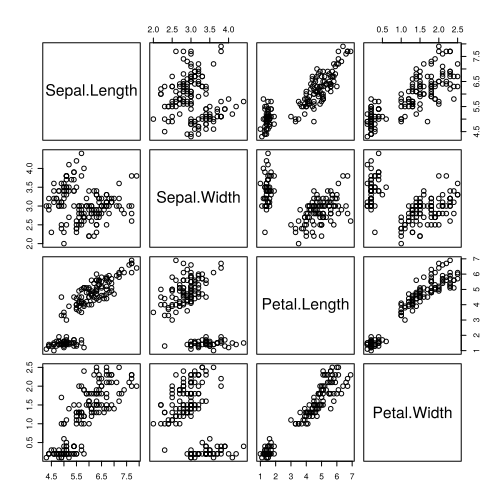

In [1]:
my.data<-iris[,1:4]
head(my.data)
pairs(my.data)

---
[Back to top](#top)
## 2. SCALING THE DATA <a name=scale><a/>

In prepration for the cluster analysis, we will scale the data so that all the variables are represented on the same scale. This can be done using the `scale` function. 

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
-0.8976739,1.01560199,-1.335752,-1.311052
-1.1392005,-0.13153881,-1.335752,-1.311052
-1.3807271,0.32731751,-1.392399,-1.311052
-1.5014904,0.09788935,-1.279104,-1.311052
-1.0184372,1.24503015,-1.335752,-1.311052
-0.5353840,1.93331463,-1.165809,-1.048667


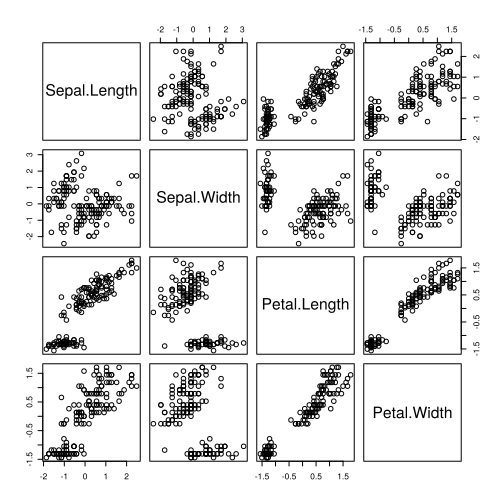

In [2]:
my.data.scaled<-scale(my.data)
head(my.data.scaled)
pairs(my.data.scaled)

---
[Back to top](#top)
## 3. THE `dist` MATRIX <a name=dist><a/>

What happens if you try different methods/*distances? It turns out that kmeans (as implemented in R) doesn't explicitely use the dist function, so we'll only evaluate the euclidean distance for this data.   


In [3]:
agg.data<-dist(my.data.scaled,method="euclidean")

---
[Back to top](#top)
## 4. DIMENSION REDUCTION <a name=pca><a/>
One potential tool to reduce the dimension of the problem is to reduce the data to its **principal components**. The hope is that most of the variability in the data can be explained by a smaller number of derived variables, expressed as linear combinations of the original variables. 

This can be done with the `princomp` function. 

In [4]:
pc.agg.data = princomp(my.data.scaled)  # this computes the principal component decomposition
summary(pc.agg.data) # this provides a summary of the "strength" of the signal in each component. 
                     # The cumulative proportion of the variance is the value of interest here. 
                     # If 2 principal components are needed to explain 95% of the variance, it means
                     # that roughly 95% of the set is 2-dimensional. 

Importance of components:
                          Comp.1    Comp.2     Comp.3      Comp.4
Standard deviation     1.7026571 0.9528572 0.38180950 0.143445939
Proportion of Variance 0.7296245 0.2285076 0.03668922 0.005178709
Cumulative Proportion  0.7296245 0.9581321 0.99482129 1.000000000

Since 2 components are enough to explain 95% of the variance in the data, we'll cluster the data provided by the first 2 components, which can be accessed _via_ the **scores** attribute of `pc.agg.data`.

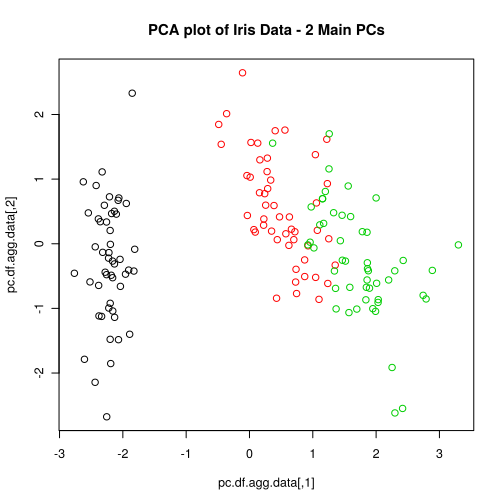

In [5]:
pc.df.agg.data = cbind(pc.agg.data$scores[,1], pc.agg.data$scores[,2])
plot(pc.df.agg.data,col=iris[,5]) # let's plot the principal component data (with labels). 
                                  # This is a 2D representation of the iris dataset
title('PCA plot of Iris Data - 2 Main PCs') 

---
[Back to top](#top)
## 5. DAVIES-BOULDIN INDEX <a name=DB><a/>
The DB index is a measure that is used to determine the optimal number of clusters in the data. For a given dataset, the optimal number of clusters is obtained by maximizing the DB index. 

In [6]:
## Index used to determine optimal number of clusters
Davies.Bouldin <- function(A, SS, m) {
  # A  - the centres of the clusters
  # SS - the within sum of squares
  # m  - the sizes of the clusters
  N <- nrow(A)   # number of clusters
  # intercluster distance
  S <- sqrt(SS/m)
  # Get the distances between centres
  M <- as.matrix(dist(A))
  # Get the ratio of intercluster/centre.dist
  R <- matrix(0, N, N)
  for (i in 1:(N-1)) {
    for (j in (i+1):N) {
      R[i,j] <- (S[i] + S[j])/M[i,j]
      R[j,i] <- R[i,j]
    }
  }
  return(mean(apply(R, 1, max)))
}

---
[Back to top](#top)
## 6. CLUSTERING AND PLOTTING <a name=clustplot><a/>
Since we don't know ahead of time how many clusters we will be using (although we suspect _via_ data exploration that $k=2$ might be a good choice), we will construct clusters for various numbers. 

In fact, we will produce 40 replicates for each number of clusters from 2 to 15 and track both the Davies-Bouldin index and the **Within Sums of Squares** (a measure of how similar observations are within each cluster, and how different they are from observations in other clusters (the value for the SS can be found by calling the attribute `withinss` on a `kmeans` object). 

If the DBI doesn't provide a clear-cut winner, the SS curve can be used: the optimal number of clusters is obtained when the slope of the SS curve changes "drastically" (so that adding more clusters doesn't provide as big a decrease anymore).

We start by setting up the number of repetitions and the loop (2, 3, ..., 15 clusters). 

In [7]:
## setting up the repetitions and display options
oldpar <- par(mfrow = c(4, 4))

N = 40   #Number of repetitions!!!!!!
max.cluster = 15   # Number of maximum number of desired clusters !!!!

## initializing values
m.errs <- rep(0, max.cluster)
m.DBI <- rep(0, max.cluster)

s.errs <- rep(0, max.cluster)
s.DBI <- rep(0, max.cluster)

Now we run 40 replicates for each number of clusters (so 560 calls to the clustering algorithm in total). For each clustering schemes, we compute the DBI and the WithinSS, and keep them in memory. 

We also print one of the clustering schemes for each of the number of clusters in the iteration. 

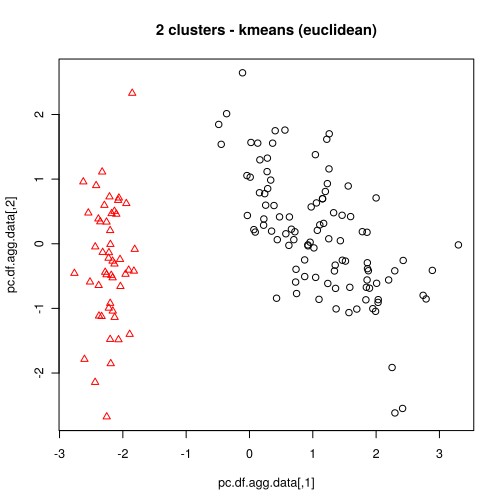

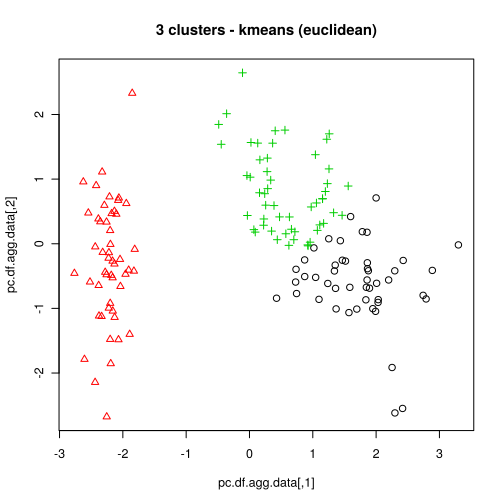

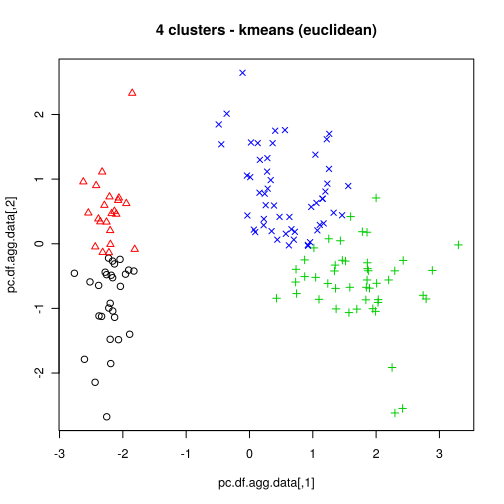

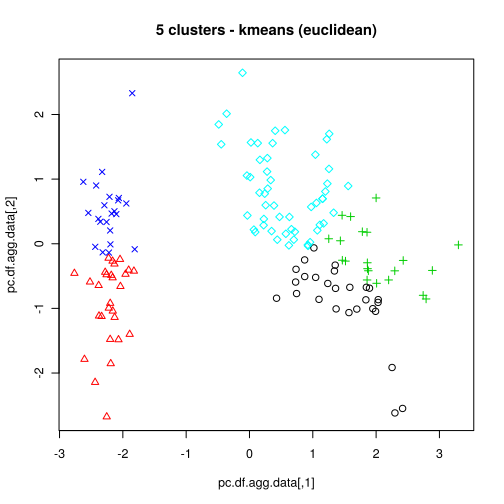

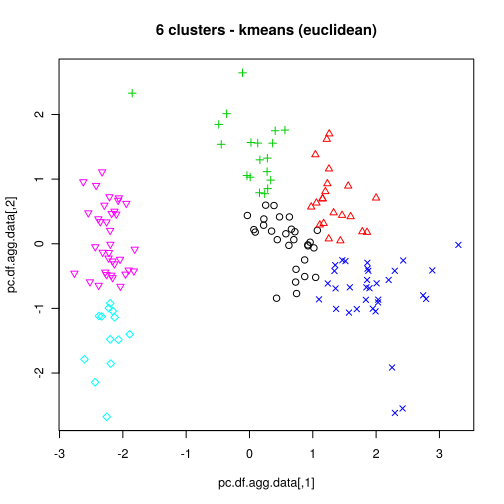

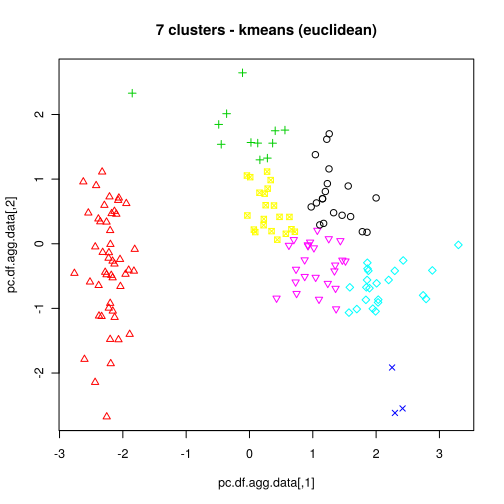

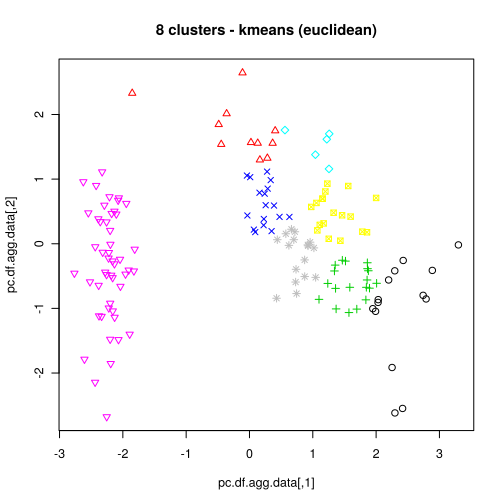

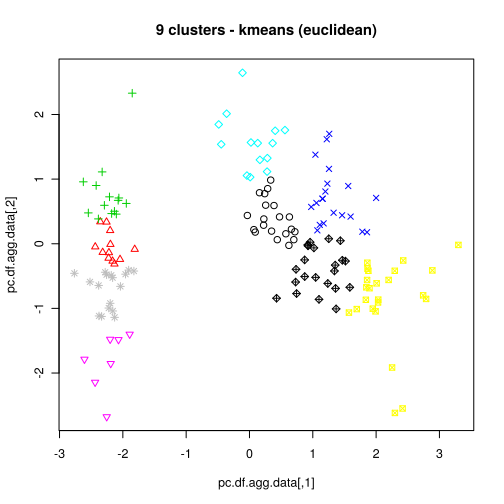

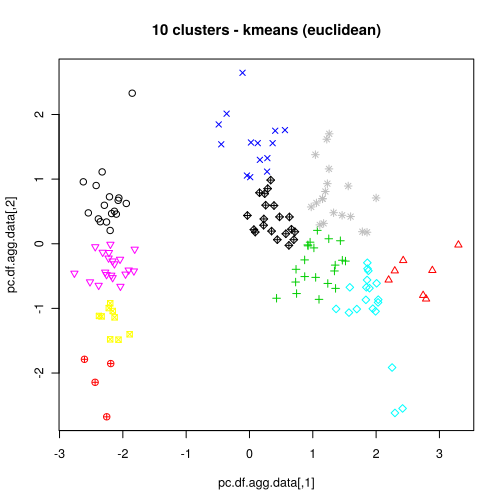

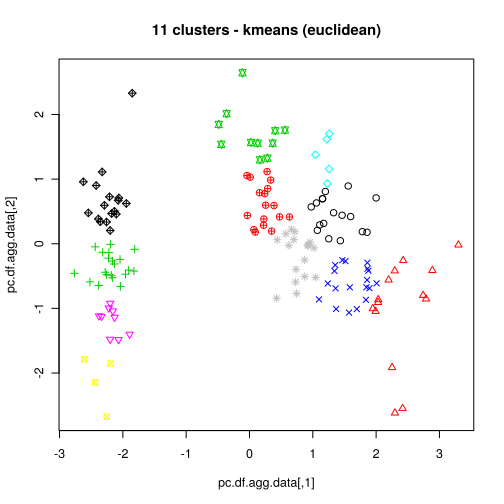

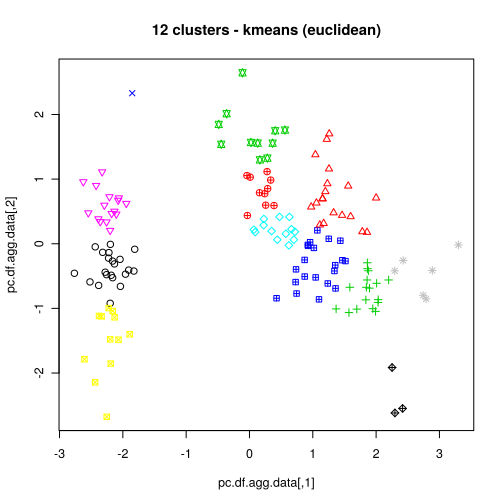

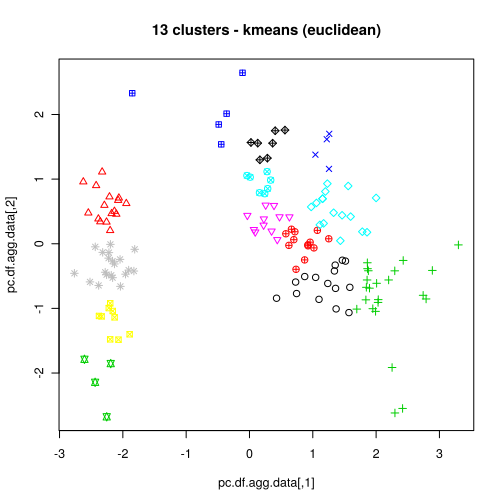

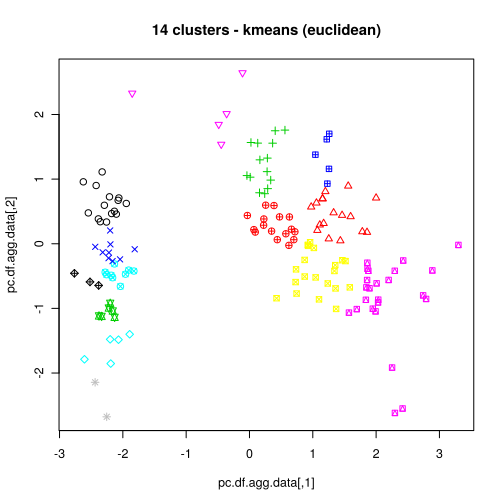

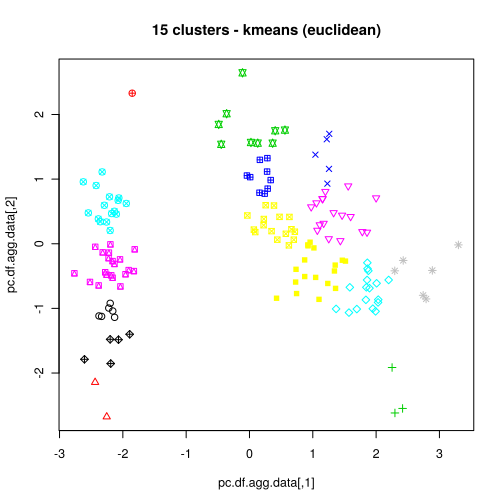

In [8]:
## clustering and plotting 
for (i in 2:max.cluster) {
  errs <- rep(0, max.cluster)
  DBI <- rep(0, max.cluster)
  
  for (j in 1:N) {
    KM <- kmeans(pc.df.agg.data, iter.max = 10,  i) # data, number of internal shifts of the cluster centres, number of clusters
    
    errs[j] <- sum(KM$withinss)
    DBI[j] <- Davies.Bouldin(KM$centers, KM$withinss, KM$size)
  }
  
  m.errs[i - 1] = mean(errs)
  s.errs[i - 1] = sd(errs)
  m.DBI[i - 1] = mean(DBI)
  s.DBI[i - 1] = sd(DBI)
  
  plot(pc.df.agg.data,col=KM$cluster, pch=KM$cluster, main=paste(i,"clusters - kmeans (euclidean)"))   
}

Since we have 40 replicates, we can come up with confidence bonds for the average DBI and WithinSS. 

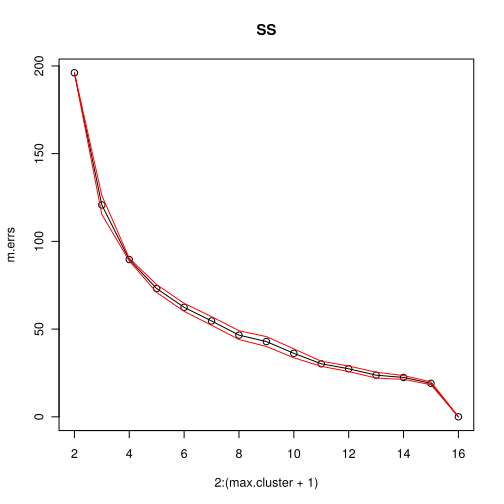

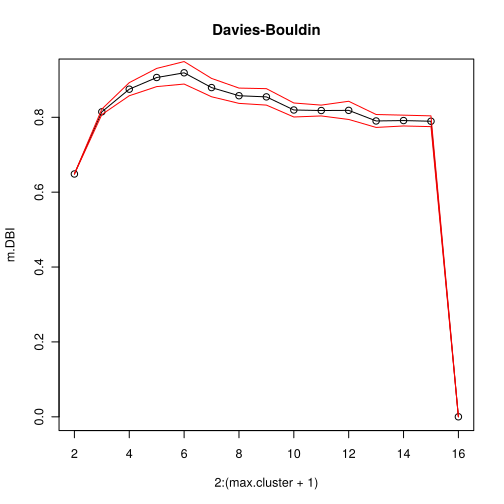

In [9]:
## Confidence bands
MSE.errs_up = m.errs + 1.96 * s.errs / sqrt(N)
MSE.errs_low = m.errs - 1.96 * s.errs / sqrt(N)

MSE.DBI_up = m.DBI + 1.96 * s.DBI / sqrt(N)
MSE.DBI_low = m.DBI - 1.96 * s.DBI / sqrt(N)


plot(2:(max.cluster+1), m.errs, main = "SS")
lines(2:(max.cluster+1), m.errs)
par(col = "red")
lines(2:(max.cluster+1), MSE.errs_up)
lines(2:(max.cluster+1), MSE.errs_low)
par(col = "black")
#
plot(2:(max.cluster+1), m.DBI, main = "Davies-Bouldin")
lines(2:(max.cluster+1), m.DBI)
par(col="red")
lines(2:(max.cluster+1), MSE.DBI_up)
lines(2:(max.cluster+1), MSE.DBI_low)
par(col = "black")

---
[Back to top](#top)
## 7. OPTIMAL NUMBER OF CLUSTERS <a name=pick><a/>
Where is the DB curve maximized? Does that match what the WithinSS curve gives us? 

In [10]:
## pick optimal number of clusters
(i_choice <- which(m.DBI==max(m.DBI[1:(length(m.DBI)-1)]))+1)

[1] 6

---
[Back to top](#top)
## 8. FINAL PLOTS <a name=final><a/>

Finally, let's plot a new clustering scheme based on the optimal choice. We cluster on the PCA reduced scaled data, but we'll plot the results in the original `iris` data. 

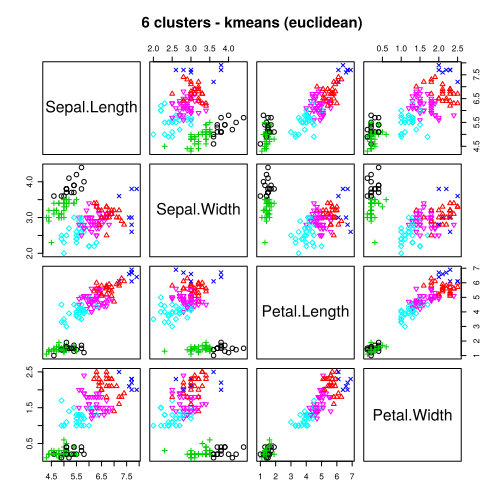

In [11]:
## plot and save the final clustering schemes
KM <- kmeans(agg.data, iter.max = 10, i_choice)
plot(iris[,1:4],col=KM$cluster, pch=KM$cluster, main=paste(i_choice,"clusters - kmeans (euclidean)"))

Do we get similar clustering schemes if we use a different metric? Let's try the manhattan distance with the `cclus` method (available with the `flexclust` package).

Loading required package: grid
Loading required package: lattice
Loading required package: modeltools
Loading required package: stats4


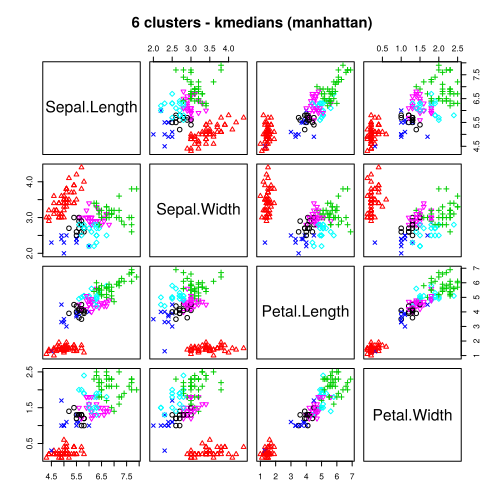

In [12]:
library(flexclust)  # more flexible clustering approach, including different algorithms and distances.
                     # worth studying further
KMed <- cclust(pc.df.agg.data, i_choice, dist="manhattan")
plot(iris[,1:4], col=predict(KMed), pch=predict(KMed), main=paste(i_choice,"clusters - kmedians (manhattan)"))


---
[Back to top](#top)
## 9. EXERCISES <a name=exer></a>
- Cluster the `kyphosis` data
- Cluster the `cars` data